# Home Credit Default Risk - Machine Learning Project  

## Project Overview  
This project aims to predict **loan default risk** using historical credit data provided by the **Home Credit dataset**.  
By analyzing multiple financial datasets from past loan applications, we extract insights to improve risk assessment and minimize losses for lenders.  
While this model is trained specifically on Home Credit’s dataset, the process—data collection, preprocessing, feature engineering, and modeling—can be adapted to other financial institutions.  

## Live Application Deployment  
This project is also deployed as an **interactive Angular + Flask application**, allowing users to observe real-time model inference.  
🔗 **Try it here:** [Live Loan Default Predictor](https://ai.fullstackista.com/ai-loan-default-predictor/)  

### Key Steps in the Project  
1. **Understanding the Problem** – Define the objective: predict loan default risk using Home Credit data.  
2. **Data Processing & Feature Engineering** – Process multiple datasets, clean missing values, extract features, and aggregate information.  
3. **Exploratory Data Analysis (EDA)** – Identify trends, correlations, and risk factors in loan applications.  
4. **Merging Datasets** – Integrate primary (`application_train.csv`) and secondary datasets (e.g., `bureau.csv`, `credit_card_balance.csv`) for a unified view.  
5. **Model Training & Hyperparameter Tuning** – Train and optimize models (e.g., LightGBM) for predictive performance.  
6. **Model Evaluation** – Validate performance using metrics such as AUC-ROC.  
7. **Final Prediction** – Apply the trained model to `application_test.csv` and generate predictions.  

## About This Notebook  
This notebook processes the `POS_CASH_balance.csv` dataset, which contains applicants' **Point of Sale (POS) and Cash Loan** repayment history.  
Processed features will be merged into the main dataset (`application_train.csv`) for model training.

## Project Notebooks  

### Main Dataset and Model Training  
- [1. Application Train (Main Dataset)](./01_application_train.ipynb)
- [2. Model Training and Final Pipeline](./02_model_training_pipeline.ipynb)  

### Secondary Datasets Processing  
- [3. Bureau Data](./03_bureau_data.ipynb)  
- [4. Bureau Balance Data](./04_bureau_balance.ipynb)  
- [5. Credit Card Balance](./05_credit_card_balance.ipynb)  
- [6. Previous Applications](./06_previous_applications.ipynb)  
- [7. POS Cash Balance](./07_pos_cash_balance.ipynb) _(Current Notebook)_
- [8. Installments Payments](./08_installments_payments.ipynb)  

### Final Prediction  
- [9. Model Predictions on Test Data](./09_model_predictions.ipynb)  
- [10. Application Test Data Processing](./10_application_test_processing.ipynb)

# Processing `POS_CASH_balance.csv` (Point of Sale & Cash Loan History)

## 1. Load Data (`POS_CASH_balance.csv`)
We start by loading the dataset and inspecting its structure to understand its key features and statistics.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
# Load dataset with a consistent naming convention
df_pos_cash_balance = pd.read_csv("/kaggle/input/home-credit-default-risk/POS_CASH_balance.csv")

## 2. Initial Data Inspection (`POS_CASH_balance.csv`)
Before processing, we inspect the dataset for potential issues such as **infinite values**, **missing values**, and other inconsistencies.

### 2.1 Checking for Infinite Values  
Infinite values (e.g., `inf`, `-inf`) can break numerical calculations and should be identified before proceeding.  
The code below scans for any **positive or negative infinite values** in the dataset.  

In [3]:
# Check for infinite values in POS_CASH_balance dataset
print("Checking for infinite values in dataset...")
inf_count = (df_pos_cash_balance == np.inf).sum().sum()
neg_inf_count = (df_pos_cash_balance == -np.inf).sum().sum()

if inf_count > 0 or neg_inf_count > 0:
    print(f"⚠️ Found {inf_count} positive and {neg_inf_count} negative infinite values!")
else:
    print("✅ No infinite values detected.")

Checking for infinite values in dataset...
✅ No infinite values detected.


### 2.2 Checking for Missing Values (NaNs)  
Missing values (**NaNs**) can affect model performance and should be handled properly.  
Here, we count the number of missing values in each column and print the results.

In [4]:
# 🔍 Check for missing values in POS_CASH_balance dataset
missing_values = df_pos_cash_balance.isnull().sum()
missing_values = missing_values[missing_values > 0]  

if not missing_values.empty:
    print("⚠️ Missing values detected in columns:")
    print(missing_values)
else:
    print("✅ No missing values detected.")

⚠️ Missing values detected in columns:
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
dtype: int64


### 2.3 Print Dataset Columns  
To get an overview of the dataset structure, we print the column names.  
This helps us understand the available features and identify any inconsistencies.

In [5]:
# Print column names
print(df_pos_cash_balance.columns)

Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'CNT_INSTALMENT',
       'CNT_INSTALMENT_FUTURE', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')


### 2.4 Detecting Extreme Values (Outliers)  

Extreme values (**outliers**) can skew model performance and lead to **unstable predictions**.  
We detect outliers using **percentile thresholds**:  

- **Above the 99th percentile** → Very large values.  
- **Below the 1st percentile** → Very small values.  

In [6]:
# Check for extreme values using percentile-based thresholds 
print("Checking for extreme values in 'POS_CASH_balance' dataset using percentile thresholds...")

# Exclude ID columns from percentile-based detection
extreme_exclude_cols = ['SK_ID_CURR', 'SK_ID_PREV']
extreme_numeric_columns = df_pos_cash_balance.select_dtypes(include=["number"]).drop(columns=extreme_exclude_cols, errors='ignore')

# Compute percentile-based thresholds
extreme_upper_threshold = extreme_numeric_columns.quantile(0.99)
extreme_lower_threshold = extreme_numeric_columns.quantile(0.01)

# Identify extreme values
extreme_large_columns = extreme_numeric_columns.max() > extreme_upper_threshold
extreme_small_columns = extreme_numeric_columns.min() < extreme_lower_threshold

# Print results
if extreme_large_columns.any():
    print(f"⚠️ Columns with very large values (above 99th percentile):\n{extreme_numeric_columns.loc[:, extreme_large_columns].max()}")
if extreme_small_columns.any():
    print(f"⚠️ Columns with very small values (below 1st percentile):\n{extreme_numeric_columns.loc[:, extreme_small_columns].min()}")
if not extreme_large_columns.any() and not extreme_small_columns.any():
    print("✅ No extreme values detected in 'POS_CASH_balance' dataset.")

Checking for extreme values in 'POS_CASH_balance' dataset using percentile thresholds...
⚠️ Columns with very large values (above 99th percentile):
MONTHS_BALANCE             -1.0
CNT_INSTALMENT             92.0
CNT_INSTALMENT_FUTURE      85.0
SK_DPD                   4231.0
SK_DPD_DEF               3595.0
dtype: float64
⚠️ Columns with very small values (below 1st percentile):
MONTHS_BALANCE   -96.0
CNT_INSTALMENT     1.0
dtype: float64


### 2.5 Checking Dataset Shape  

The dataset's shape provides a quick view of its size, showing the number of **rows** (loan records) and **columns** (features).  

In [7]:
# Check the shape of the POS_CASH_balance dataset
print("DataFrame Shape:", df_pos_cash_balance.shape)

DataFrame Shape: (10001358, 8)


### 2.6 Viewing Sample Data (`head()`)  

To understand the dataset, we display the **first few rows**.  
This helps verify that data is loaded correctly and gives an initial sense of feature distributions.  

In [8]:
# Display the first few rows of the DataFrame
print("First few rows of POS_CASH_balance DataFrame:")
display(df_pos_cash_balance.head())

First few rows of POS_CASH_balance DataFrame:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


### 2.7 Dataset Summary (`info()`)  

The `info()` function provides:  
- **Column names and types** (e.g., integer, float, categorical).  
- **Non-null counts** (to check for missing data).  
- **Memory usage**, which is useful for optimizing performance.  

In [9]:
# Get a concise summary of the DataFrame
print("DataFrame Info:")
df_pos_cash_balance.info()

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


### 2.8 Descriptive Statistics  

We generate summary statistics for:  
- **Numeric columns** (`describe()`) → Mean, standard deviation, min/max, and quartiles.  
- **Categorical columns** (`describe(include='object')`) → Count of unique values, most frequent categories.  
This helps in **understanding distributions** and identifying possible anomalies.  

In [10]:
# Get summary statistics of numeric and categorical columns
print("Descriptive Statistics (Numeric Columns):")
display(df_pos_cash_balance.describe())

print("Descriptive Statistics (Categorical Columns):")
display(df_pos_cash_balance.describe(include="object"))


Descriptive Statistics (Numeric Columns):


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


Descriptive Statistics (Categorical Columns):


,NAME_CONTRACT_STATUS
count,10001358
unique,9
top,Active
freq,9151119


## 3. Initial Data Cleaning (`POS_CASH_balance.csv`)
After identifying potential issues, we clean the dataset by handling **infinite values, categorical features, and potential misclassified columns**.

### 3.1 Replacing Infinite Values  
Since infinite values (`inf`, `-inf`) can interfere with model training, we replace them with `NaN` to handle them properly later.  

In [11]:
# Replace infinite values with NaN before handling missing values
df_pos_cash_balance.replace([np.inf, -np.inf], np.nan, inplace=True)
print("✅ Infinite values replaced with NaN.")

✅ Infinite values replaced with NaN.


### 3.2 Converting Categorical Features  
Some columns are stored as `object` or numeric types but should be categorical.  
We identify and convert relevant columns to the **category dtype** for efficiency and proper encoding.  

In [12]:
# Convert manually identified categorical columns
categorical_cols = ["NAME_CONTRACT_STATUS"]
df_pos_cash_balance[categorical_cols] = df_pos_cash_balance[categorical_cols].astype("category")

print("✅ Converted manually identified categorical columns to 'category'.")

✅ Converted manually identified categorical columns to 'category'.


### 3.3 Checking Unique Values in Categorical Columns  
To ensure correct data types, we print the number of unique values in categorical columns.  
This helps verify if any unexpected categories exist.  

In [13]:
# Check unique values in categorical columns
print("Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_pos_cash_balance[col].nunique()} unique values")

Unique values in categorical columns:
NAME_CONTRACT_STATUS: 9 unique values


### 3.4 Checking Decimal Values in Float Columns  

Some columns are stored as floats but should contain only **integer values** (e.g., counts of transactions or installments).  
To verify correctness, we check how many rows in each float column contain non-integer (decimal) values.  
This helps detect potential **data type mismatches** or **unexpected floating-point precision issues**.  

In [14]:
# Check if float columns contain decimal values
print("\nChecking if float columns contain decimal values:")
decimal_counts = df_pos_cash_balance[['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']].map(lambda x: x % 1 != 0).sum()

print(decimal_counts)


Checking if float columns contain decimal values:
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
dtype: int64


### 3.5 Extracting Unique Decimal Values  

To further investigate potential **data type mismatches**, we extract and display **unique decimal values** in float columns.  
This helps confirm whether numerical features expected to be integers contain unintended floating-point values.  

In [15]:
# Extract unique decimal values
print("\nChecking unique decimal values:")
for col in ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']:
    unique_decimals = df_pos_cash_balance[col].dropna().map(lambda x: x % 1).unique()
    print(f"{col}: {unique_decimals}")


Checking unique decimal values:
CNT_INSTALMENT: [0.]
CNT_INSTALMENT_FUTURE: [0.]


### 3.6 Converting Count-Based Columns to Integers  

Certain columns represent **count-based features**, but they may be mistakenly stored as floats.  
To ensure consistency, we convert these columns to **integer type**, preserving numerical integrity.  

In [16]:
# Convert columns to integers
df_pos_cash_balance[['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']] = df_pos_cash_balance[['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']].astype('Int64')

print("✅ Converted CNT_INSTALMENT and CNT_INSTALMENT_FUTURE to integers.")

✅ Converted CNT_INSTALMENT and CNT_INSTALMENT_FUTURE to integers.


### 3.7 Displaying Updated Data Types  

After data cleaning, we check if all columns have the correct data types.  
This ensures that categorical, numeric, and ID columns are properly assigned before further processing.  

In [17]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types:")
print(df_pos_cash_balance.dtypes)
pd.reset_option('display.max_rows')  

✅ Updated Data Types:
SK_ID_PREV                  int64
SK_ID_CURR                  int64
MONTHS_BALANCE              int64
CNT_INSTALMENT              Int64
CNT_INSTALMENT_FUTURE       Int64
NAME_CONTRACT_STATUS     category
SK_DPD                      int64
SK_DPD_DEF                  int64
dtype: object


### 3.8 Handling Missing Values  
Missing values can impact model performance, so we analyze and handle them based on their percentage.  

#### 3.8.1 Checking for Missing Values  
We first identify missing values in each column to understand their distribution.  

In [18]:
# Check for missing values
pd.set_option('display.max_rows', None) 
print("Missing values in each column:")
print(df_pos_cash_balance.isnull().sum())
pd.reset_option('display.max_rows')  

Missing values in each column:
SK_ID_PREV                   0
SK_ID_CURR                   0
MONTHS_BALANCE               0
CNT_INSTALMENT           26071
CNT_INSTALMENT_FUTURE    26087
NAME_CONTRACT_STATUS         0
SK_DPD                       0
SK_DPD_DEF                   0
dtype: int64


#### 3.8.2 Calculating Missing Value Percentages  
To categorize missing values, we define thresholds:  
- **Low**: Less than 1% missing (likely safe to fill with median/mean).  
- **Moderate**: 1%–20% missing (requires careful handling).  
- **High**: More than 50% missing (usually dropped unless critical).  

In [19]:
# Define missing value thresholds 
low_threshold = 1  # Less than 1% missing
moderate_threshold = 20  # Between 1% and 20% missing
high_threshold = 50  # More than 50% missing 

# Calculate missing value percentage
missing_percent = (df_pos_cash_balance.isnull().sum() / len(df_pos_cash_balance)) * 100  

# Display missing percentages
print("Missing Value Percentages:")
display(missing_percent[missing_percent > 0].sort_values(ascending=False).apply(lambda x: f"{x:.2f}%")) 

Missing Value Percentages:


CNT_INSTALMENT_FUTURE    0.26%
CNT_INSTALMENT           0.26%
dtype: object

### 3.9 Filling Missing Values  

To ensure data completeness, we fill missing values in both **numeric** and **categorical** columns using appropriate strategies.  
- **Numeric values** → Filled with **median** (robust to outliers).  
- **Categorical values** → Filled with **mode** (most frequent category).  

In [20]:
# Fill numeric columns with median
numeric_cols_to_fill = ["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE"]
df_pos_cash_balance[numeric_cols_to_fill] = df_pos_cash_balance[numeric_cols_to_fill].fillna(df_pos_cash_balance[numeric_cols_to_fill].median())

print("✅ Filled numeric missing values with median.")

✅ Filled numeric missing values with median.


### 3.10 Final Missing Values Check  
After filling missing values, we perform a final check to confirm that **no NaNs remain** in the dataset.  

In [21]:
# 🔍 Final Missing Values Check
print("Final Missing Values Check:")
print(df_pos_cash_balance.isnull().sum().sum())

Final Missing Values Check:
0


### 3.11 Checking for Duplicates  
Duplicate rows can cause data leakage and distort model training.  
We check for duplicates and ensure that no redundant rows exist.  

In [22]:
# Check for duplicate rows
print("Number of duplicate rows:", df_pos_cash_balance.duplicated().sum())

Number of duplicate rows: 0


### 3.12 Saving the Cleaned Dataset  

Before saving, we **verify all column data types** to ensure correctness after processing.  

We save the cleaned dataset for the following purpose:  

**Feature Ranges for Dummy Data** → This dataset is later used in the **Angular + Flask app** to generate test data for predictions.  

In [23]:
# Display all columns and their data types
pd.set_option('display.max_rows', None) 
print("✅ Updated Data Types for df_pos_cash_balance:")
print(df_pos_cash_balance.dtypes)
pd.reset_option('display.max_rows')  

✅ Updated Data Types for df_pos_cash_balance:
SK_ID_PREV                  int64
SK_ID_CURR                  int64
MONTHS_BALANCE              int64
CNT_INSTALMENT              Int64
CNT_INSTALMENT_FUTURE       Int64
NAME_CONTRACT_STATUS     category
SK_DPD                      int64
SK_DPD_DEF                  int64
dtype: object


In [24]:
df_pos_cash_balance.to_csv("cleaned_pos_cash_balance.csv")
df_pos_cash_balance.to_pickle("cleaned_pos_cash_balance.pkl")

print("✅ Cleaned POS Cash Balance dataset saved successfully!")

✅ Cleaned POS Cash Balance dataset saved successfully!


## 4. Exploratory Data Analysis (`POS_CASH_balance.csv`)

EDA helps us **understand data distributions, correlations, and patterns** that might impact feature engineering.  

### 4.1 Summary Statistics  

We first generate summary statistics for both **numeric** and **categorical features** to check distributions, outliers, and data consistency.  

In [25]:
### Summary Statistics
pd.set_option('display.max_columns', None)

# Numeric summary
print("Summary Statistics (Numeric Features):")
display(df_pos_cash_balance.describe().T)

# Categorical summary
print("Summary Statistics (Categorical Features):")
display(df_pos_cash_balance.describe(include=["category"]).T)

pd.reset_option('display.max_columns')  

Summary Statistics (Numeric Features):


,count,mean,std,min,25%,50%,75%,max
SK_ID_PREV,10001358.0,1903216.598957,535846.530722,1000001.0,1434405.0,1896565.0,2368963.0,2843499.0
SK_ID_CURR,10001358.0,278403.863306,102763.74509,100001.0,189550.0,278654.0,367429.0,456255.0
MONTHS_BALANCE,10001358.0,-35.012588,26.06657,-96.0,-54.0,-28.0,-13.0,-1.0
CNT_INSTALMENT,10001358.0,17.076383,11.982223,1.0,10.0,12.0,24.0,92.0
CNT_INSTALMENT_FUTURE,10001358.0,10.474753,11.095983,0.0,3.0,7.0,14.0,85.0
SK_DPD,10001358.0,11.606928,132.714043,0.0,0.0,0.0,0.0,4231.0
SK_DPD_DEF,10001358.0,0.654468,32.762491,0.0,0.0,0.0,0.0,3595.0


Summary Statistics (Categorical Features):


,count,unique,top,freq
NAME_CONTRACT_STATUS,10001358,9,Active,9151119


### 4.2 Correlation Analysis  

We calculate feature correlations to detect **strongly related variables**.  
This helps identify **redundant features** and potential **new interactions** for modeling.  

In [26]:
# Select only numeric columns from df_pos_cash_balance
numeric_data = df_pos_cash_balance.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_data.corr()

# Display top 10 most correlated feature pairs (excluding self-correlations)
print("Top 10 Most Correlated Features in `df_pos_cash_balance`:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations
print(corr_pairs.head(10))

Top 10 Most Correlated Features in `df_pos_cash_balance`:
CNT_INSTALMENT_FUTURE  CNT_INSTALMENT           0.871297
CNT_INSTALMENT         CNT_INSTALMENT_FUTURE    0.871297
MONTHS_BALANCE         CNT_INSTALMENT           0.335102
CNT_INSTALMENT         MONTHS_BALANCE           0.335102
CNT_INSTALMENT_FUTURE  MONTHS_BALANCE           0.270819
MONTHS_BALANCE         CNT_INSTALMENT_FUTURE    0.270819
SK_DPD_DEF             SK_DPD                   0.245782
SK_DPD                 SK_DPD_DEF               0.245782
SK_DPD_DEF             SK_ID_PREV               0.004848
SK_ID_PREV             SK_DPD_DEF               0.004848
dtype: float64


### Key Takeaways:
- **Strong correlation (>0.8)** between `CNT_INSTALMENT_FUTURE` and `CNT_INSTALMENT`, as well as with `MONTHS_BALANCE`, suggests potential redundancy among these features.
- `SK_DPD` and `SK_DPD_DEF` exhibit **moderate correlation (~0.25)**, indicating they might capture similar delinquency-related information.
- Some correlations are **weak (<0.3)**, meaning they may not have strong linear relationships, but **non-linear interactions** could still be useful.
- **Redundant features** might need **removal or transformation** to prevent multicollinearity in modeling.

### 4.3 Correlation Heatmap  

We visualize the correlation matrix using a **heatmap** to detect strongly related features.  
This helps identify **redundant features** and possible **new interactions** for modeling.  

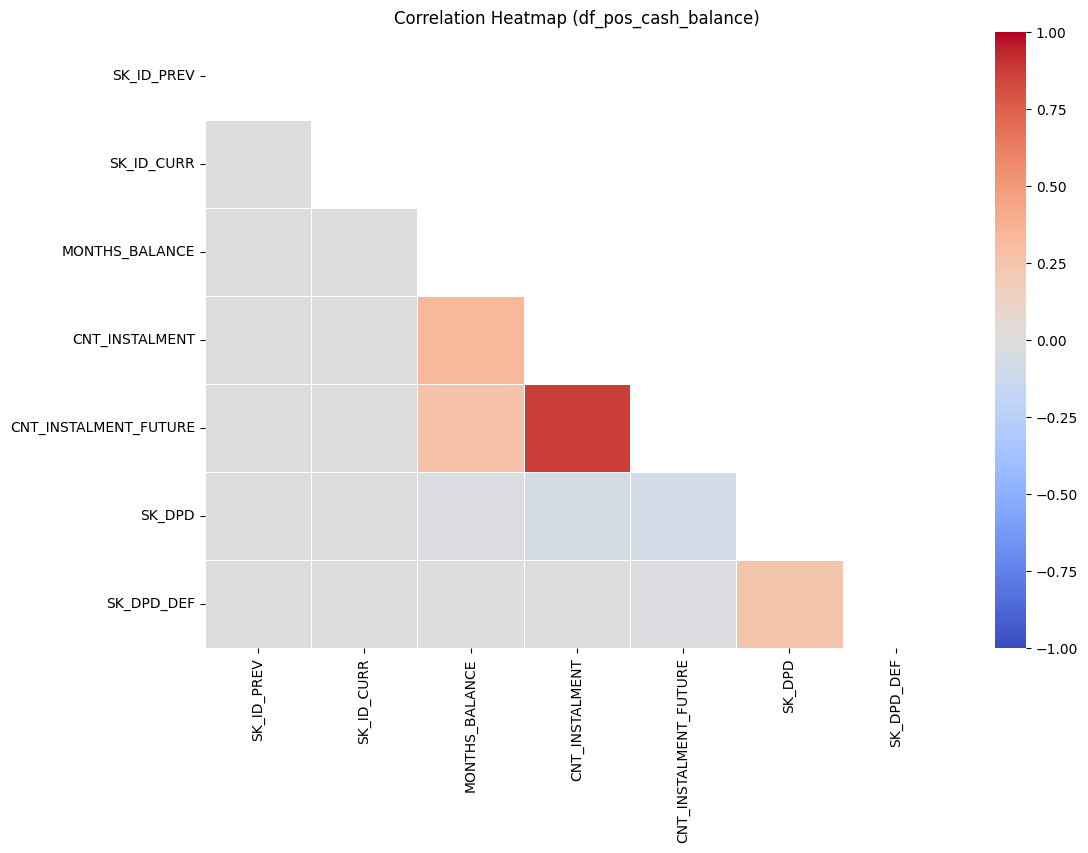

In [27]:
# Visualize the correlation matrix using a heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set figure size
plt.figure(figsize=(12, 8))

# Create heatmap
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    annot=False,
    cmap="coolwarm", 
    linewidths=0.5, 
    vmin=-1, vmax=1
)

# Title
plt.title("Correlation Heatmap (df_pos_cash_balance)")
plt.show()

### Key Takeaways:
- The heatmap confirms **high correlation** between `CNT_INSTALMENT_FUTURE`, `CNT_INSTALMENT`, and `MONTHS_BALANCE`, suggesting possible redundancy.
- `SK_DPD` and `SK_DPD_DEF` show **moderate correlation**, indicating they capture similar delinquency patterns.
- Strongly correlated features may require **removal, transformation, or dimensionality reduction** to avoid multicollinearity.

### 4.4 Visualizing Outliers  

We plot boxplots of key numerical features to detect **potential extreme values**.  
Since LightGBM handles outliers efficiently, **no transformations** are applied.  

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


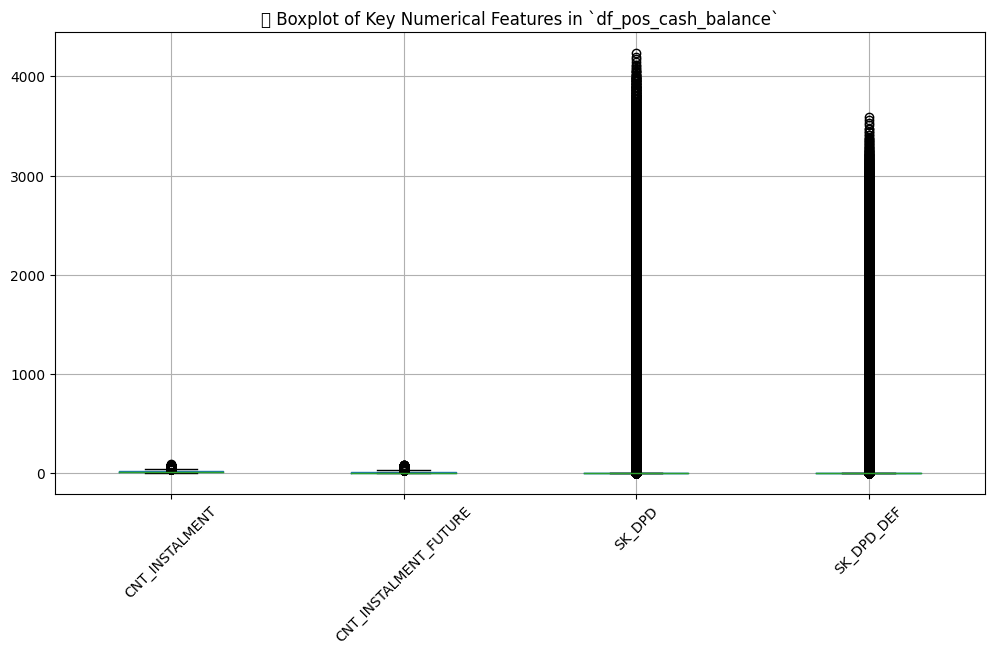

In [28]:
# Selected key numeric features for outlier detection
outlier_columns = [
    "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD", "SK_DPD_DEF"
]

# Create boxplot
plt.figure(figsize=(12, 6))
df_pos_cash_balance[outlier_columns].boxplot()

# Title
plt.title("📊 Boxplot of Key Numerical Features in `df_pos_cash_balance`")
plt.xticks(rotation=45)  
plt.show()

### Key Takeaways:
- Boxplots reveal **extreme values** in `SK_DPD` and `SK_DPD_DEF`, which may indicate significant outliers.
- `CNT_INSTALMENT` and `CNT_INSTALMENT_FUTURE` show minimal outliers, suggesting stable distributions.
- While **LightGBM handles outliers efficiently**, other models (e.g., logistic regression, SVM) may require **transformation or outlier removal** to improve performance.

### 4.5 Pair Plot Analysis

Pair plots help visualize relationships between multiple numerical features.
- Scatter plots show relationships between feature pairs.
- Histograms along the diagonal show feature distributions.

To improve performance, we sample 10,000 rows from the dataset.

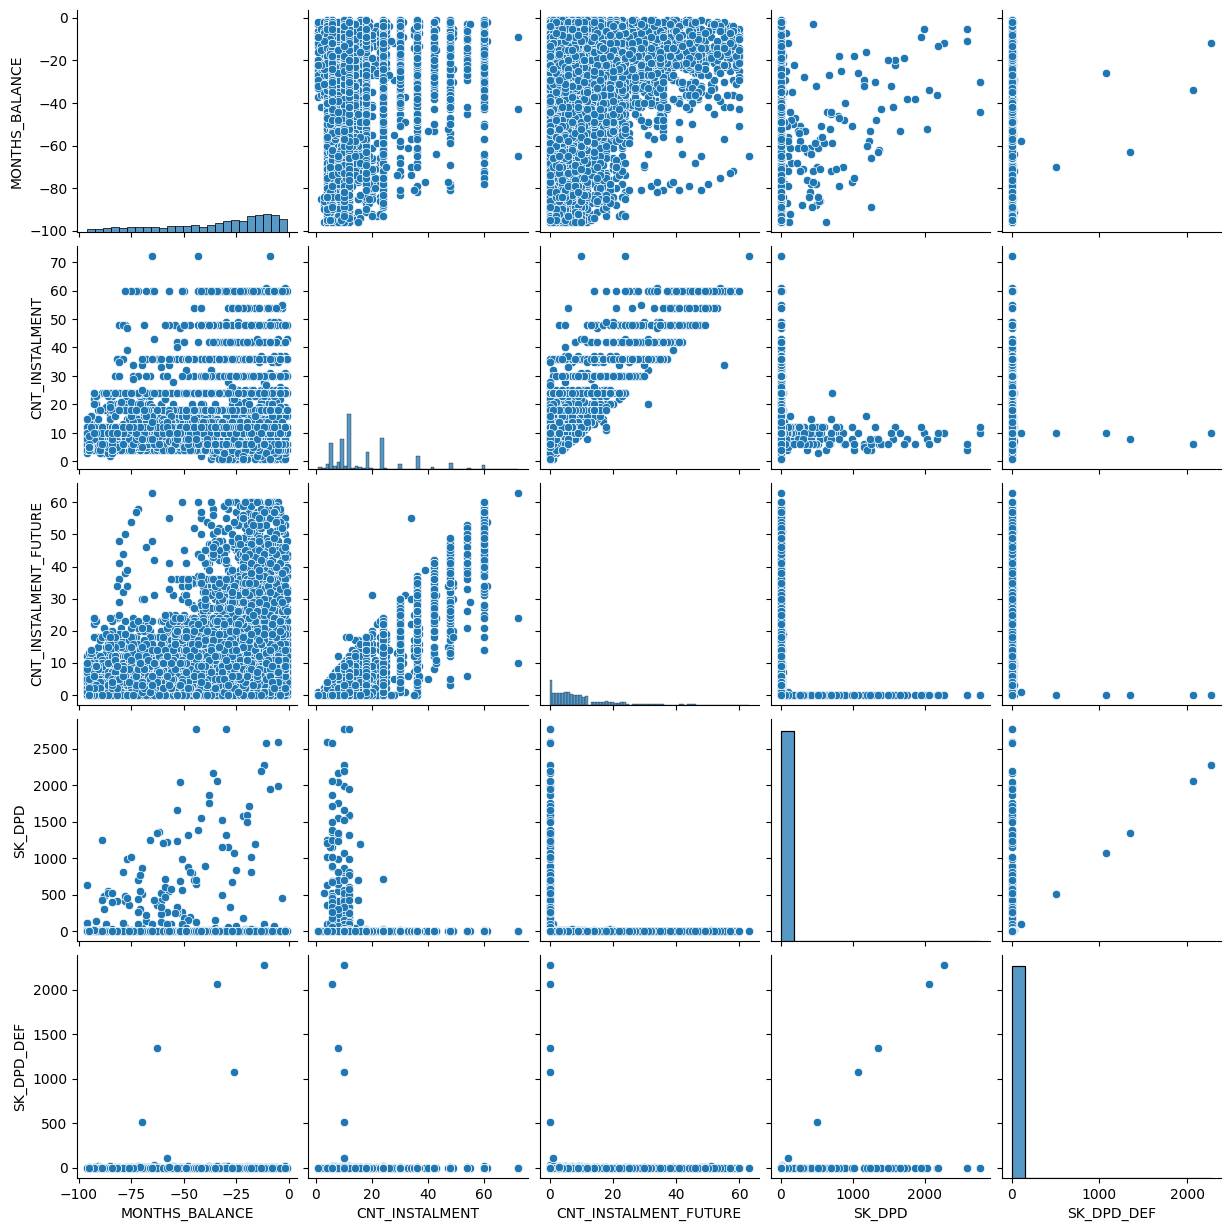

In [29]:
# Selected key numerical features for pair plot
numeric_features = [
    "MONTHS_BALANCE", "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD", "SK_DPD_DEF"
]

# Reduce dataset to 10,000 rows for performance
df_sample = df_pos_cash_balance[numeric_features].sample(n=10000, random_state=42)

# Create pair plot
sns.pairplot(df_sample)
plt.show()

### Key Takeaways:
- The **pair plot visualizes feature relationships**, showing **linear** correlations (e.g., `CNT_INSTALMENT_FUTURE` vs. `CNT_INSTALMENT`) and **non-linear patterns**.
- `SK_DPD` and `SK_DPD_DEF` exhibit **distinct cluster patterns**, indicating different distributions of delinquency-related data.
- Sampling **10,000 rows** improves visualization performance without losing important trends.

### 4.6 Group-wise Analysis

Group-wise analysis helps us understand how numerical features vary across different categorical groups.
- We examine how a numerical feature is distributed across different categorical values.
- Boxplots are used to visualize variations and identify potential trends.
- This helps detect disparities and patterns that could be relevant for further modeling.

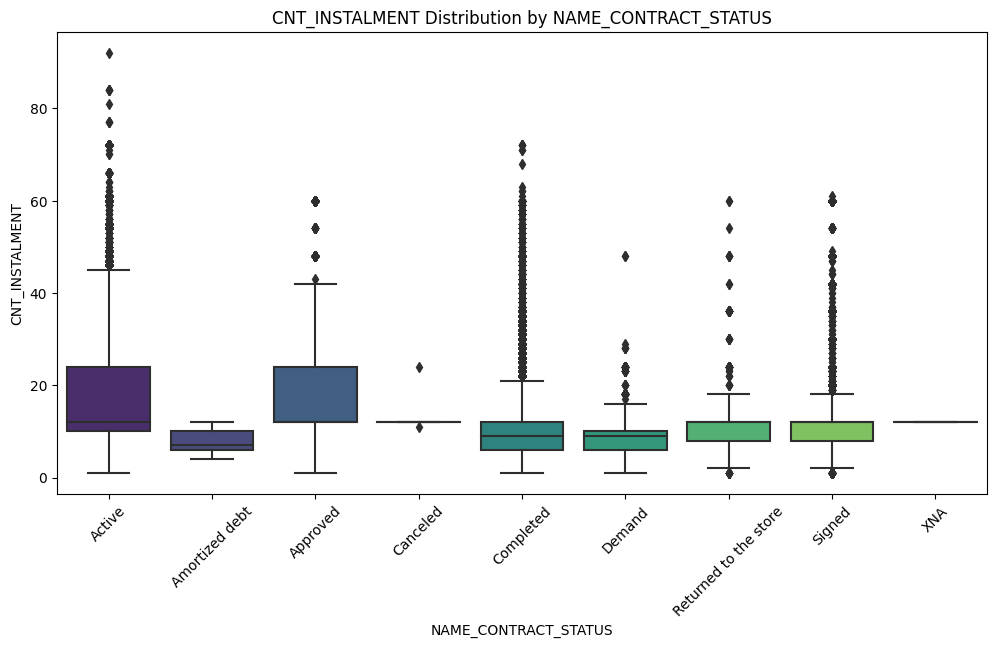

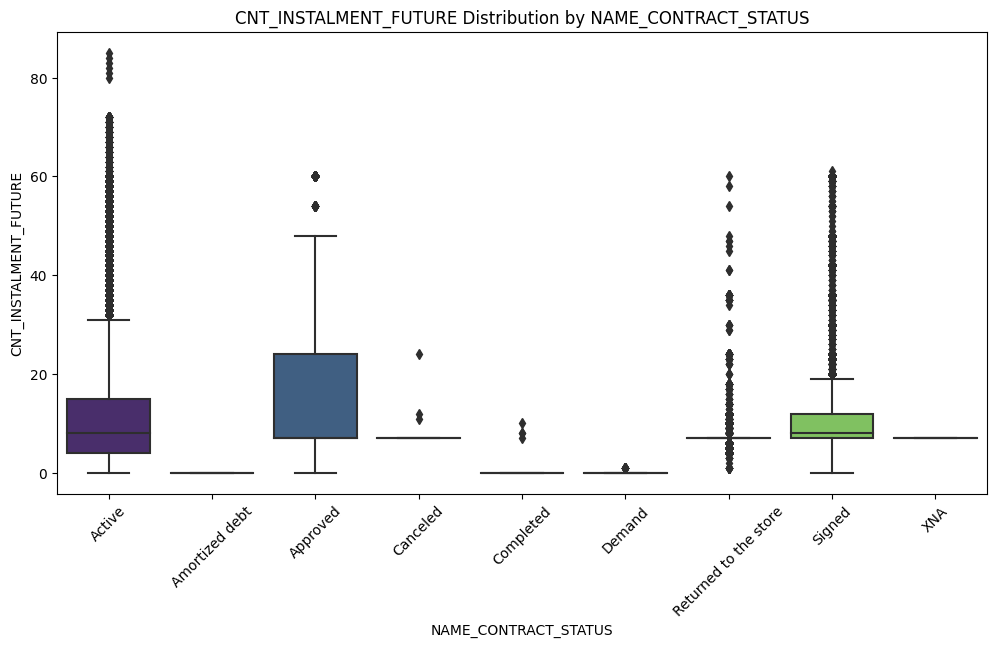

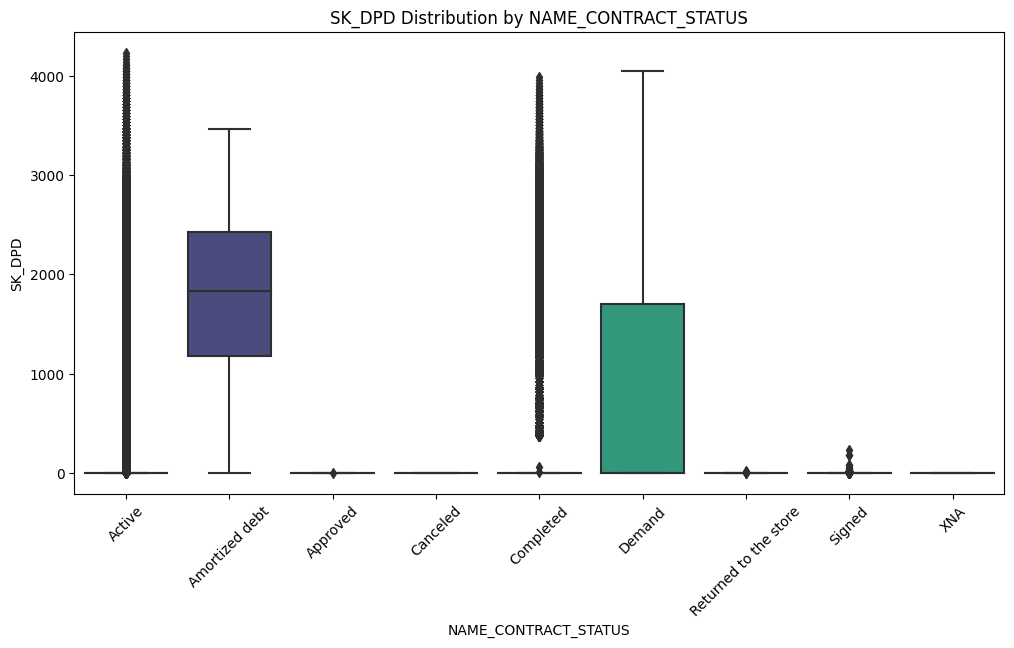

In [30]:
# Selected categorical column for group-wise analysis
categorical_col_boxplot = "NAME_CONTRACT_STATUS"

# Selected numerical columns for analysis
numeric_cols_boxplot = ["CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE", "SK_DPD"]

# Generate boxplots for each numeric feature
for numeric_col in numeric_cols_boxplot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=categorical_col_boxplot, y=numeric_col, data=df_pos_cash_balance, palette="viridis", dodge=False)
    plt.title(f"{numeric_col} Distribution by {categorical_col_boxplot}")
    plt.xticks(rotation=45)
    plt.show()

### Key Takeaways:
- `CNT_INSTALMENT` and `CNT_INSTALMENT_FUTURE` vary significantly across **contract statuses**, with **Active** and **Approved** showing higher distributions.
- `SK_DPD` (days past due) is **notably high** for **Amortized debt** and **Demand** contracts, indicating higher delinquency risk in these categories.
- Understanding these distributions helps in **feature selection** and may reveal **risk patterns** useful for predictive modeling.

### 4.7 Time-wise Analysis
We analyze how key features evolve over time to detect **trends, seasonality, or anomalies**.  
This helps in identifying patterns that might improve feature engineering. 

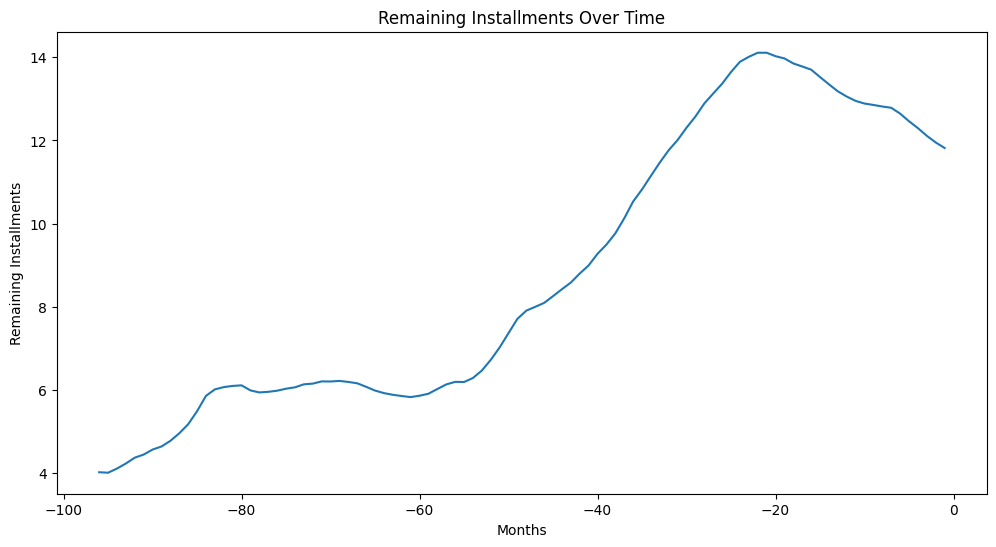

In [31]:
# Loan repayment over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pos_cash_balance, x="MONTHS_BALANCE", y="CNT_INSTALMENT_FUTURE", ci=None)
plt.title("Remaining Installments Over Time")
plt.xlabel("Months")
plt.ylabel("Remaining Installments")
plt.show()

### Key Takeaways:
- The number of **remaining installments** generally **increases** over time before peaking and then **declining**, likely reflecting repayment schedules.
- The trend suggests a structured repayment pattern, with a possible **seasonality effect** or policy-driven impact on loan structures.
- Identifying **anomalies or deviations** in this trend could help detect irregular payment behaviors, useful for **risk assessment**.

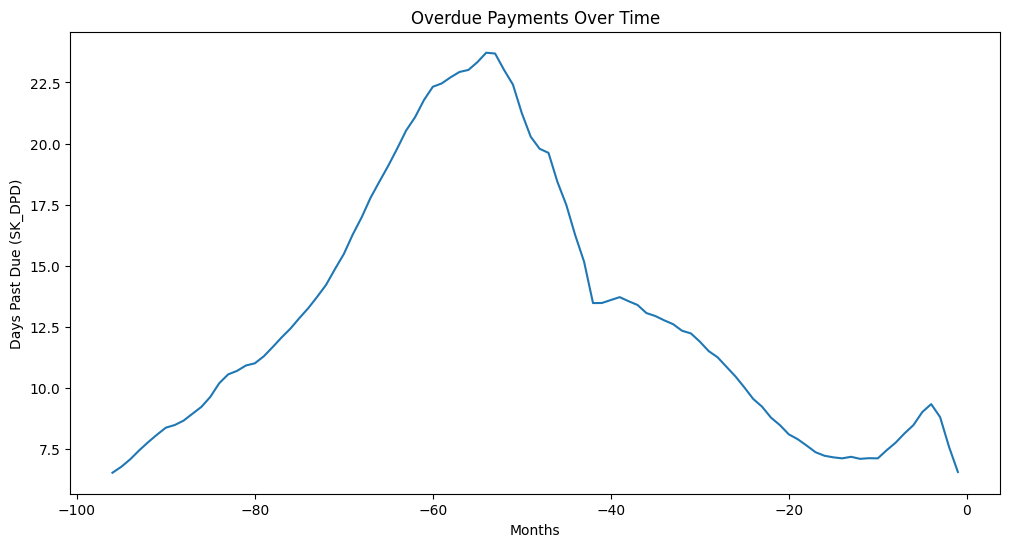

In [32]:
# Overdue payments over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_pos_cash_balance, x="MONTHS_BALANCE", y="SK_DPD", ci=None)
plt.title("Overdue Payments Over Time")
plt.xlabel("Months")
plt.ylabel("Days Past Due (SK_DPD)")
plt.show()

### Key Takeaways:
- **Overdue payments (`SK_DPD`) increased steadily**, peaking around **60 months before the present**, before declining.
- The drop in overdue payments could indicate **policy changes, debt restructuring, or repayment enforcement**.
- Identifying **periods of high delinquency** can help in **risk modeling** and understanding borrower behavior over time.

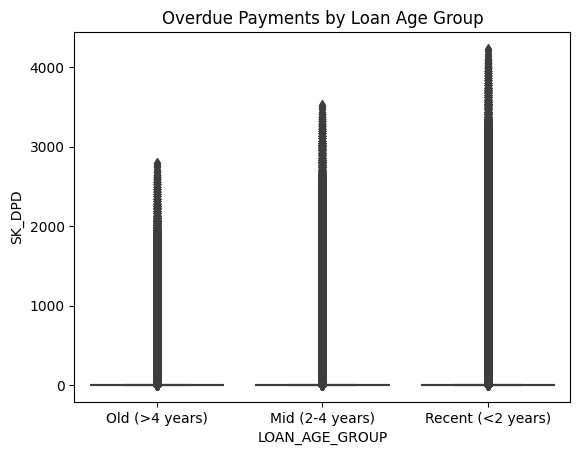

In [33]:
# Segment loans into old vs. recent
df_pos_cash_balance["LOAN_AGE_GROUP"] = pd.cut(
    df_pos_cash_balance["MONTHS_BALANCE"], 
    bins=[-100, -48, -24, 0], 
    labels=["Old (>4 years)", "Mid (2-4 years)", "Recent (<2 years)"]
)

sns.boxplot(x="LOAN_AGE_GROUP", y="SK_DPD", data=df_pos_cash_balance)
plt.title("Overdue Payments by Loan Age Group")
plt.show()

### Key Takeaways:
- **Overdue payments (`SK_DPD`) appear consistent** across loan age groups, suggesting that delinquency risk does not significantly decrease with loan maturity.
- Loans **younger than 2 years** show **high variance**, indicating potential instability in early repayment periods.
- This segmentation can help assess whether **loan age influences repayment behavior**, informing **credit risk models**.

### 4.8 Joint Plot Analysis
We use scatter plots with histograms to visualize relationships between numerical features.  
This helps identify patterns, correlations, and potential outliers.

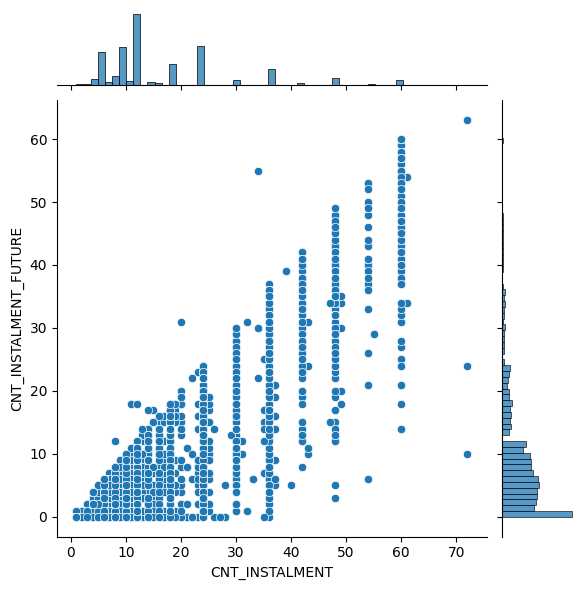

In [34]:
# Sample 10,000 rows for performance
df_sample_scatter = df_pos_cash_balance.sample(n=10000, random_state=42)

# Scatter plot of Total Installments vs Remaining Installments
sns.jointplot(x="CNT_INSTALMENT", y="CNT_INSTALMENT_FUTURE", data=df_sample_scatter, kind="scatter")

plt.show()

### Key Takeaways:
- A **strong positive correlation** exists between `CNT_INSTALMENT` and `CNT_INSTALMENT_FUTURE`, confirming that higher total installments generally lead to more remaining installments.
- The **histograms** reveal distribution patterns, with most loans having a low number of installments.
- Outliers with **high remaining installments** could indicate **early-stage loans** or **delayed repayments**, potentially useful for risk assessment.

### 4.9 Additional EDA Visualisations

We plot histograms to visualize the distribution of key numerical features.  
This helps detect skewness, outliers, and possible data transformations.

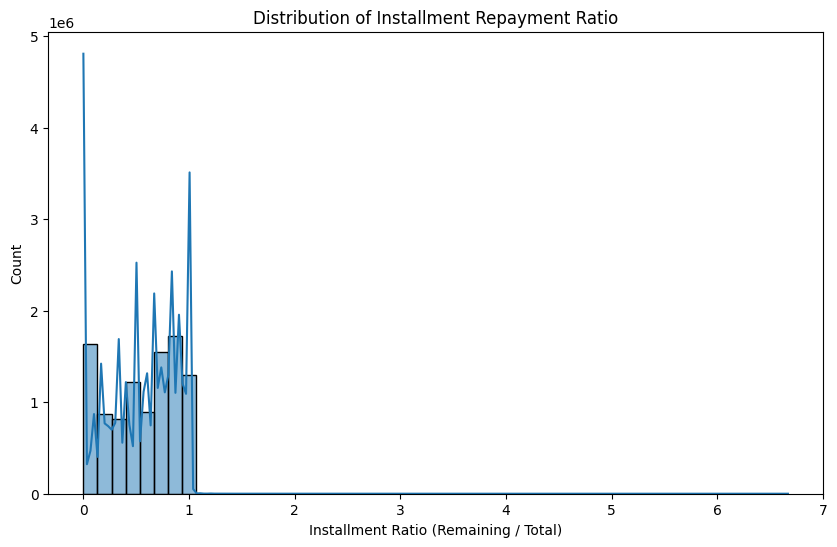

In [35]:
# Distribution of installment repayment ratio
plt.figure(figsize=(10, 6))
sns.histplot(df_pos_cash_balance["CNT_INSTALMENT_FUTURE"] / df_pos_cash_balance["CNT_INSTALMENT"], bins=50, kde=True)
plt.title("Distribution of Installment Repayment Ratio")
plt.xlabel("Installment Ratio (Remaining / Total)")
plt.ylabel("Count")
plt.show()

### Key Takeaways:
- The **installment repayment ratio** is mostly concentrated around **0 to 1**, indicating that most loans follow a standard repayment schedule.
- A few cases exceed **1.0**, suggesting possible **data anomalies, early repayments, or reporting errors**.
- This distribution can help in **feature engineering**, such as creating a categorical variable for **high vs. low repayment ratios**.

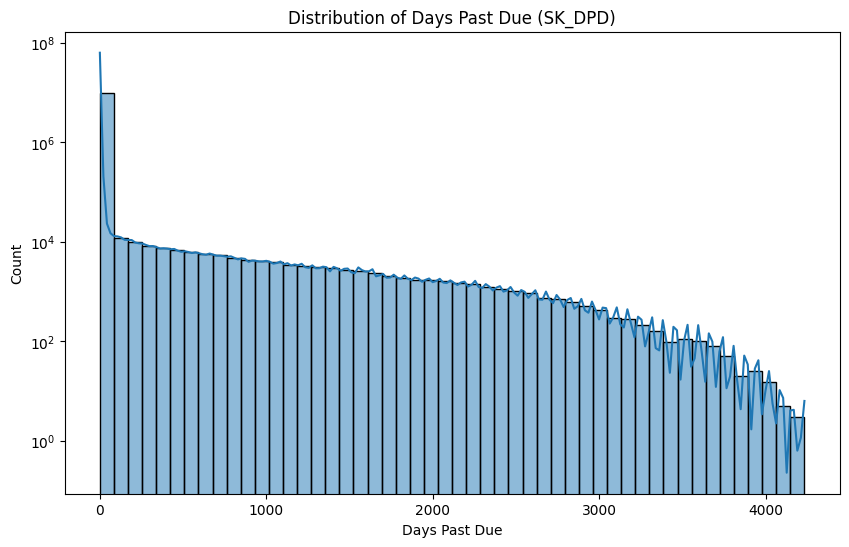

In [36]:
# Distribution of days past due
plt.figure(figsize=(10, 6))
sns.histplot(df_pos_cash_balance["SK_DPD"], bins=50, kde=True)
plt.title("Distribution of Days Past Due (SK_DPD)")
plt.xlabel("Days Past Due")
plt.ylabel("Count")
plt.yscale("log")  
plt.show()

### Key Takeaways:
- The **distribution is highly skewed**, with most overdue payments (`SK_DPD`) concentrated near **zero**, indicating that most borrowers repay on time.
- A **long tail** extends beyond **4000 days**, suggesting **a subset of chronic defaulters** with extremely delayed payments.
- The **log scale** helps highlight trends across different ranges, which may be useful for **creating risk categories or threshold-based features**.

We analyze the distribution of key categorical features using bar plots.  
This helps identify class imbalances, dominant categories, and rare values.

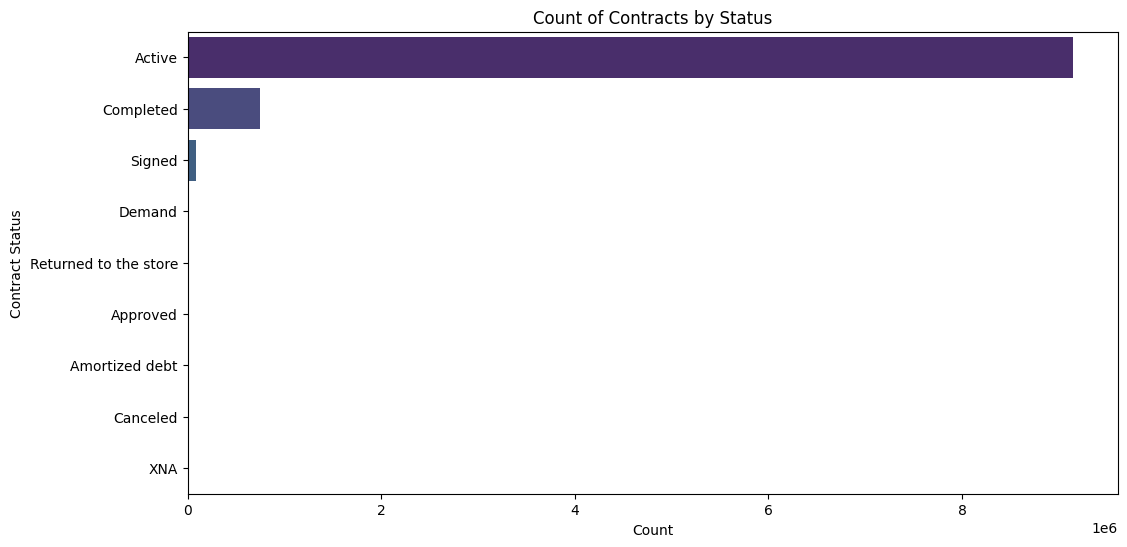

In [37]:
# Count of contracts by status
plt.figure(figsize=(12, 6))
sns.countplot(y=df_pos_cash_balance["NAME_CONTRACT_STATUS"], order=df_pos_cash_balance["NAME_CONTRACT_STATUS"].value_counts().index, palette="viridis")
plt.title("Count of Contracts by Status")
plt.xlabel("Count")
plt.ylabel("Contract Status")
plt.show()

### Key Takeaways:
- The **majority of contracts are in "Active" status**, significantly outweighing other categories.
- A smaller number of contracts are **"Completed" or "Signed"**, indicating that most loans remain open rather than closed.
- Understanding contract distribution helps assess **portfolio composition** and may influence **default risk analysis**.

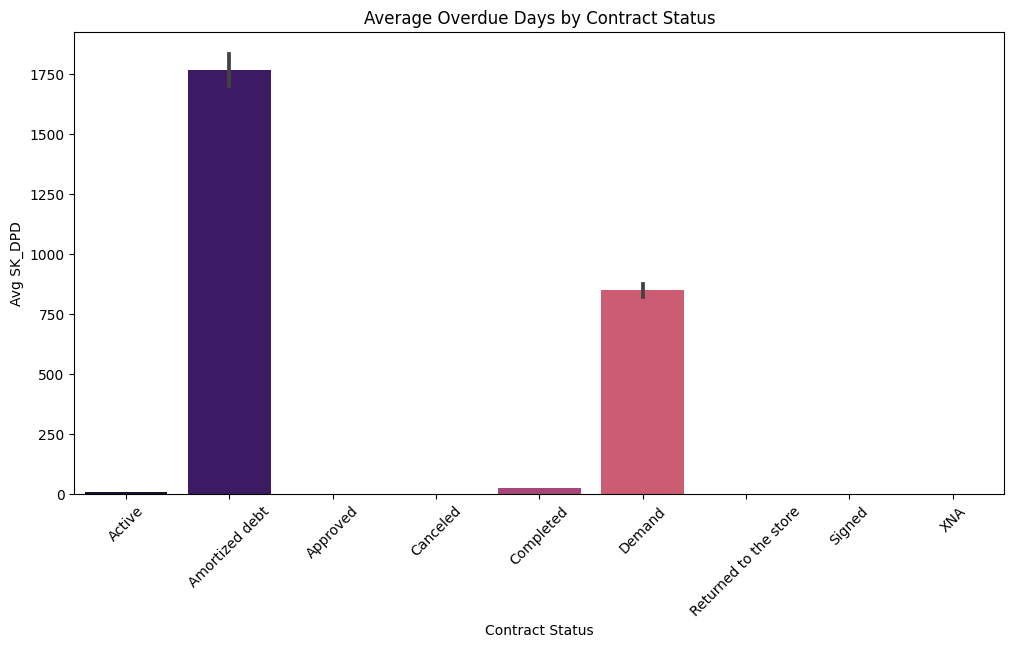

In [38]:
# Average overdue days by contract status
plt.figure(figsize=(12, 6))
sns.barplot(x="NAME_CONTRACT_STATUS", y="SK_DPD", data=df_pos_cash_balance, estimator=np.mean, palette="magma")
plt.xticks(rotation=45)
plt.title("Average Overdue Days by Contract Status")
plt.xlabel("Contract Status")
plt.ylabel("Avg SK_DPD")
plt.show()

### Key Takeaways:
- **"Amortized debt" contracts have the highest overdue days**, suggesting a high-risk category with prolonged delinquencies.
- **"Demand" contracts also show significant overdue days**, indicating potential late repayment trends.
- **"Active" contracts have minimal overdue days**, reflecting better repayment behavior, likely due to ongoing monitoring.

## 5. Feature Engineering (`POS_CASH_balance.csv`)
We create new features to enhance predictive power by summarizing key attributes of the dataset.  
Feature engineering helps capture meaningful patterns that might improve model performance.

### 5.1 Credit Activity Features  
These features count the number of **POS loans per client**, distinguishing between **active** and **completed** loans.

In [39]:
# Group by SK_ID_CURR and calculate loan counts
pos_cash_credit_activity = df_pos_cash_balance.groupby("SK_ID_CURR").agg(
    pos_cash_balance_NUM_POS_LOANS=("SK_ID_PREV", "nunique"),  # Total number of POS loans per client
    pos_cash_balance_NUM_ACTIVE_POS_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Active").sum()),  # Count active POS loans
    pos_cash_balance_NUM_COMPLETED_POS_LOANS=("NAME_CONTRACT_STATUS", lambda x: (x == "Completed").sum())  # Count completed POS loans
).reset_index()

# Preview the new features before merging
display(pos_cash_credit_activity.head())

,SK_ID_CURR,pos_cash_balance_NUM_POS_LOANS,pos_cash_balance_NUM_ACTIVE_POS_LOANS,pos_cash_balance_NUM_COMPLETED_POS_LOANS
0,100001,2,7,2
1,100002,1,19,0
2,100003,3,26,2
3,100004,1,3,1
4,100005,1,9,1


### 5.2 Time-Based Features (`POS_CASH_balance.csv`)

### 5.2 Time-Based Features  
These features capture **time-related aspects** of POS loans, such as **credit duration, time since last update, and remaining installments**.

In [40]:
# Group by SK_ID_CURR and calculate time-related statistics
pos_cash_time_features = df_pos_cash_balance.groupby("SK_ID_CURR").agg(
    pos_cash_balance_AVG_POS_CREDIT_DURATION=("MONTHS_BALANCE", lambda x: abs(x.mean()) / 12),  # Avg duration of POS credit in years
    pos_cash_balance_TIME_SINCE_LAST_POS_UPDATE=("MONTHS_BALANCE", lambda x: abs(x.max()) / 12),  # Time since last POS update in years
    pos_cash_balance_AVG_REMAINING_INSTALLMENT_TIME=("CNT_INSTALMENT_FUTURE", lambda x: abs(x.mean()))  # Avg remaining installments
).reset_index()

# Preview the new features before merging
display(pos_cash_time_features.head())

,SK_ID_CURR,pos_cash_balance_AVG_POS_CREDIT_DURATION,pos_cash_balance_TIME_SINCE_LAST_POS_UPDATE,pos_cash_balance_AVG_REMAINING_INSTALLMENT_TIME
0,100001,6.046296,4.416667,1.444444
1,100002,0.833333,0.083333,15.000000
2,100003,3.648810,1.500000,5.785714
3,100004,2.125000,2.000000,2.250000
4,100005,1.666667,1.250000,7.181818


### 5.3 Credit Overdue Features (`POS_CASH_balance.csv`)

### 5.3 Credit Overdue Features  
These features track **overdue POS credits**, including **total overdue days, maximum overdue days, and severe overdue instances**.

In [41]:
# Group by SK_ID_CURR and calculate overdue-related statistics
pos_cash_overdue_features = df_pos_cash_balance.groupby("SK_ID_CURR").agg(
    pos_cash_balance_NUM_OVERDUE_POS_CREDITS=("SK_DPD", lambda x: (x > 0).sum()),  # Count overdue POS credits
    pos_cash_balance_TOTAL_OVERDUE_DAYS_POS=("SK_DPD", "sum"),  # Sum of overdue days across all POS credits
    pos_cash_balance_MAX_OVERDUE_DAYS_POS=("SK_DPD", "max"),  # Maximum overdue days for any POS credit
    pos_cash_balance_NUM_SEVERE_OVERDUE_POS=("SK_DPD_DEF", lambda x: (x > 0).sum())  # Count severe overdue instances
).reset_index()

# Preview the new features before merging
display(pos_cash_overdue_features.head())

,SK_ID_CURR,pos_cash_balance_NUM_OVERDUE_POS_CREDITS,pos_cash_balance_TOTAL_OVERDUE_DAYS_POS,pos_cash_balance_MAX_OVERDUE_DAYS_POS,pos_cash_balance_NUM_SEVERE_OVERDUE_POS
0,100001,1,7,7,1
1,100002,0,0,0,0
2,100003,0,0,0,0
3,100004,0,0,0,0
4,100005,0,0,0,0


### 5.4 Categorical Features Aggregation (`POS_CASH_balance.csv`)

### 5.4 Categorical Features Aggregation  
These features summarize **contract statuses**, including **percentage of active months, most common contract type, and return occurrences**.

In [42]:
# Compute categorical feature aggregations
pos_cash_balance_categorical_features = df_pos_cash_balance.groupby("SK_ID_CURR").agg(
    pos_cash_balance_PERCENT_ACTIVE_MONTHS=("NAME_CONTRACT_STATUS", lambda x: (x == "Active").sum() / len(x)),  # % Active months
    pos_cash_balance_MOST_COMMON_CONTRACT_STATUS=("NAME_CONTRACT_STATUS", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),  # Most common status
    pos_cash_balance_HAS_RETURNED_CONTRACT=("NAME_CONTRACT_STATUS", lambda x: 1 if (x == "Returned to the store").any() else 0)  # Binary flag for returns
).reset_index()

# Preview the new features before merging
display(pos_cash_balance_categorical_features.head())

,SK_ID_CURR,pos_cash_balance_PERCENT_ACTIVE_MONTHS,pos_cash_balance_MOST_COMMON_CONTRACT_STATUS,pos_cash_balance_HAS_RETURNED_CONTRACT
0,100001,0.777778,Active,0
1,100002,1.000000,Active,0
2,100003,0.928571,Active,0
3,100004,0.750000,Active,0
4,100005,0.818182,Active,0


## 6. Aggregation (`POS_CASH_balance.csv`)
We aggregate numerical and categorical features at the client level to summarize loan-related patterns. This reduces dataset size while retaining essential information.

### 6.1 Aggregate All Numeric and Categorical Columns
- Numerical features are aggregated using mean, sum, max, and min to capture overall trends.
- Categorical features are aggregated using the most frequent category per client.

This step ensures that client-level insights are preserved for modeling while reducing redundancy.

In [43]:
# Aggregate df_pos_cash_balance before merging
print("\nAggregating df_pos_cash_balance by SK_ID_CURR...")

# Exclude SK_ID_PREV (loan-level unique identifier)
agg_numeric_columns = df_pos_cash_balance.select_dtypes(include=['number']).drop(columns=['SK_ID_PREV'], errors='ignore')

# Aggregate numerical features (without std)
agg_funcs = ['mean', 'sum', 'max', 'min']  # Keeping it consistent with bureau
agg_numeric = agg_numeric_columns.groupby('SK_ID_CURR').agg(agg_funcs)

# Rename columns to avoid multi-index issue
agg_numeric.columns = ['pos_cash_agg_' + '_'.join(col) for col in agg_numeric.columns]
agg_numeric.reset_index(inplace=True)

# Optimize categorical feature aggregation
agg_categorical_columns = df_pos_cash_balance.select_dtypes(include=['object', 'category']).drop(columns=['SK_ID_PREV'], errors='ignore')

if not agg_categorical_columns.empty:
    # Instead of mode(), use value_counts().idxmax() for speed
    agg_categorical_columns = df_pos_cash_balance[['SK_ID_CURR']].join(agg_categorical_columns)
    
    agg_categorical = agg_categorical_columns.groupby('SK_ID_CURR').agg(lambda x: x.value_counts().idxmax() if not x.empty else "Unknown")
    agg_categorical.columns = ['pos_cash_agg_' + col + '_most_frequent' for col in agg_categorical.columns]
    agg_categorical.reset_index(inplace=True)

    # Merge aggregated numerical and categorical features
    df_pos_cash_balance_aggregated = agg_numeric.merge(agg_categorical, on="SK_ID_CURR", how="left")
else:
    df_pos_cash_balance_aggregated = agg_numeric

# Check new shape
print(f"✅ Aggregation complete. New df_pos_cash_balance_aggregated shape: {df_pos_cash_balance_aggregated.shape}")



Aggregating df_pos_cash_balance by SK_ID_CURR...
✅ Aggregation complete. New df_pos_cash_balance_aggregated shape: (337252, 23)


## 7. Merging (`POS_CASH_balance.csv`)
We merge all newly created feature tables into a single dataset using a **left join on SK_ID_CURR**.  
This ensures that no client records are lost while incorporating the engineered features.

In [44]:
# Function to safely merge dataframes and print debugging info
def safe_merge(df_main, df_new, merge_on="SK_ID_CURR", name=""):
    """ Merges two dataframes and prints sanity checks """
    prev_shape = df_main.shape
    df_main = df_main.merge(df_new, on=merge_on, how="left")

    print(f"✅ Merged {name}: {prev_shape} -> {df_main.shape}")
    print(f"⚠️ Missing Values in {name} After Merge:\n{df_main.isnull().sum()[df_main.isnull().sum() > 0]}")
    print("-" * 50)

    return df_main

# Apply Safe Merges at the End
df_pos_cash_balance_aggregated = safe_merge(df_pos_cash_balance_aggregated, pos_cash_credit_activity, name="pos_cash_credit_activity")
df_pos_cash_balance_aggregated = safe_merge(df_pos_cash_balance_aggregated, pos_cash_time_features, name="pos_cash_time_features")
df_pos_cash_balance_aggregated = safe_merge(df_pos_cash_balance_aggregated, pos_cash_overdue_features, name="pos_cash_overdue_features")
df_pos_cash_balance_aggregated = safe_merge(df_pos_cash_balance_aggregated, pos_cash_balance_categorical_features, name="pos_cash_balance_categorical_features")

print("✅ All POS_CASH_balance feature tables merged successfully!")

✅ Merged pos_cash_credit_activity: (337252, 23) -> (337252, 26)
⚠️ Missing Values in pos_cash_credit_activity After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged pos_cash_time_features: (337252, 26) -> (337252, 29)
⚠️ Missing Values in pos_cash_time_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged pos_cash_overdue_features: (337252, 29) -> (337252, 33)
⚠️ Missing Values in pos_cash_overdue_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ Merged pos_cash_balance_categorical_features: (337252, 33) -> (337252, 36)
⚠️ Missing Values in pos_cash_balance_categorical_features After Merge:
Series([], dtype: int64)
--------------------------------------------------
✅ All POS_CASH_balance feature tables merged successfully!


### 7.1 Feature Validation
Before saving, we validate the dataset by checking for:  
- **Missing values** (standard NaNs and hidden NaNs stored as text)  
- **Infinite values** (Inf or -Inf, which can cause issues in modeling)  

Once verified, the aggregated dataset is saved.

In [45]:
# Step 1: Check for standard NaN values after merging
missing_values_pos_cash = df_pos_cash_balance_aggregated.isna().sum()
missing_values_pos_cash = missing_values_pos_cash[missing_values_pos_cash > 0]
print("\nStandard Missing Values in Aggregated POS_CASH_balance Features After Merging:")
print(missing_values_pos_cash if not missing_values_pos_cash.empty else "✅ No standard NaN values detected.")

# Step 2: Check for hidden NaNs (empty strings or "nan" stored as a string) after merging
hidden_nans_pos_cash = (df_pos_cash_balance_aggregated == "").sum() + (df_pos_cash_balance_aggregated == "nan").sum()
hidden_nans_pos_cash = hidden_nans_pos_cash[hidden_nans_pos_cash > 0]
print("\nHidden NaNs (Empty Strings or 'nan' as Text) in Aggregated POS_CASH_balance Features After Merging:")
print(hidden_nans_pos_cash if not hidden_nans_pos_cash.empty else "✅ No hidden NaNs detected.")


Standard Missing Values in Aggregated POS_CASH_balance Features After Merging:
✅ No standard NaN values detected.

Hidden NaNs (Empty Strings or 'nan' as Text) in Aggregated POS_CASH_balance Features After Merging:
✅ No hidden NaNs detected.


In [46]:
# Step 3: Check for Inf values after merging
inf_values_pos_cash = df_pos_cash_balance_aggregated.replace([np.inf, -np.inf], np.nan).isna().sum()
inf_values_pos_cash = inf_values_pos_cash[inf_values_pos_cash > 0]

print("\nInfinite Values in Aggregated POS_CASH_balance Features After Merging:")
if inf_values_pos_cash.empty:
    print("✅ No Inf values detected.")
else:
    print(inf_values_pos_cash)


Infinite Values in Aggregated POS_CASH_balance Features After Merging:
✅ No Inf values detected.


In [47]:
# Save the final aggregated POS_CASH_balance dataset in CSV and Pickle formats
df_pos_cash_balance_aggregated.to_csv("pos_cash_balance_aggregated.csv", index=False)
df_pos_cash_balance_aggregated.to_pickle("pos_cash_balance_aggregated.pkl")

print("✅ POS_CASH_balance aggregated dataset saved successfully!")

✅ POS_CASH_balance aggregated dataset saved successfully!
